# Global Wheat Detection

This is the training part of my second solution to the [Global Wheat Detection](kaggle.com/c/global-wheat-detection) competition.

The complete solution is divided into a training notebook and an inference notebook and is based on a Pytorch implementation of EfficientDet. This, along with all other attributions can be found in `Readme.md`.

## Setup

### Imports
These are the general imports. I will import more specialized modules when working with the network

In [1]:
import torch
import pandas as pd
import numpy as np
from glob import glob
import os
import cv2
import apex
import re
import matplotlib.pyplot as plt
import time
from datetime import datetime
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import random

### Detect OS

First, the operating system has to be selected, because in the future, I want to be able to use this notebook on both my Windows machine at home and the Kaggle system. The current version has only been tested on Windows.

In [2]:
system = os.name
if system == 'posix':
    kaggle = True
    windows = False
    print('running on kaggle')
elif system == 'nt':
    kaggle = False
    windows = True
    print('running on windows')
else:
    print('unknown system')

running on windows


### Select the GPU the Notebook has access to

Because I am going to be developing this notebook on one GPU while at the same time training my network on my other GPU, I will be limiting the access this notebook has to my secondary GPU in order to make sure it does not interfere with the training process

In [3]:
if windows:
    from IPython.core.interactiveshell import InteractiveShell
    InteractiveShell.ast_node_interactivity = 'all'
    import os
    os.environ['TF_MIN_GPU_MULTIPROCESSOR_COUNT']='4'
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    from tensorflow.python.client import device_lib
    print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14549359039460015701
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11329624570227486042
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9881563968
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11517905452294032551
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:26:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14169551655205281553
physical_device_desc: "device: XLA_GPU device"
]


### APEX

Apex proved to be very helpful, especially since its VRAM optimization allowed me to use a batch size of 4 512x512 images during training. Without the batch size was limited to 2.

In [4]:
apex_on = True
if apex_on:
    if kaggle:
        ! pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ../input/nvidiaapex/.
if apex_on:
    from apex import amp


## The Dataset

The first goal will be to format the dataset, so it can be used for training by the network. The initial state of the dataset is a CSV file containing information on all of the images with bounding boxes in the training dataset.

### Making the Dataset

In [5]:
labels = pd.read_csv('../input/global-wheat-detection/train.csv')

In [6]:
labels

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1
...,...,...,...,...,...
147788,5e0747034,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2
147789,5e0747034,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2
147790,5e0747034,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2
147791,5e0747034,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2


The dataset contains the columns:
* `image_id`: the unique identifier for each of the pictures. There is a row for every bounding box, so each picture can occur multiple times
* `width` & `height`: number of pixels of width and height of the pictures
* `bbox`: coordinates for the ground-truth bounding box. They are in pixels and follow the format \[x_min, y_min, width, height\]
* `source`: source of the picture. The pictures of the wheat were taken by different institutions across the world and the reason for the competition is that the models trained seem to work very well in one part of the world, but not generalize very well.

In [7]:
num_labels = np.shape(labels.image_id.unique())[0]
num_labels

3373

In [8]:
num_pics = len(os.listdir("../input/global-wheat-detection/train"))
num_pics

3422

In [9]:
num_pics - num_labels

49

This means there are 49 pictures that do not contain any boxes. These images don't have entries in the dataframe.

In [10]:
labels.bbox

0          [834.0, 222.0, 56.0, 36.0]
1         [226.0, 548.0, 130.0, 58.0]
2         [377.0, 504.0, 74.0, 160.0]
3         [834.0, 95.0, 109.0, 107.0]
4         [26.0, 144.0, 124.0, 117.0]
                     ...             
147788      [64.0, 619.0, 84.0, 95.0]
147789    [292.0, 549.0, 107.0, 82.0]
147790    [134.0, 228.0, 141.0, 71.0]
147791     [430.0, 13.0, 184.0, 79.0]
147792     [875.0, 740.0, 94.0, 61.0]
Name: bbox, Length: 147793, dtype: object

Now the individual coordinates of the bounding boxes need to be extracted. The coordinates are saved as strings, so I will use the `pandas.Series.str.extract()` method along with a regular expression to extract the coordinates

In [11]:
pixels = labels.bbox.str.extract(r'(\d+\.*\d*)\,\s(\d+\.*\d*)\,\s(\d+\.*\d*)\,\s(\d+\.*\d*)')
pixels.columns = ['x_min', 'y_min', 'w_box', 'h_box']

In [12]:
labels = pd.concat([labels,pixels], axis = 1)

In [13]:
labels.head(5)

,image_id,width,height,bbox,source,x_min,y_min,w_box,h_box
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0


In [14]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147793 entries, 0 to 147792
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   image_id  147793 non-null  object
 1   width     147793 non-null  int64 
 2   height    147793 non-null  int64 
 3   bbox      147793 non-null  object
 4   source    147793 non-null  object
 5   x_min     147793 non-null  object
 6   y_min     147793 non-null  object
 7   w_box     147793 non-null  object
 8   h_box     147793 non-null  object
dtypes: int64(2), object(7)
memory usage: 10.1+ MB


The width, height, x_min, y_min, w_box and h_box columns are still in a str format, but they can be easily transformed with the pandas.Series.astype('float64') method

In [15]:
labels.width = labels.width.astype('float64')
labels.height = labels.height.astype('float64')
labels.x_min = labels.x_min.astype('float64')
labels.y_min = labels.y_min.astype('float64')
labels.w_box = labels.w_box.astype('float64')
labels.h_box = labels.h_box.astype('float64')

In [16]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147793 entries, 0 to 147792
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   image_id  147793 non-null  object 
 1   width     147793 non-null  float64
 2   height    147793 non-null  float64
 3   bbox      147793 non-null  object 
 4   source    147793 non-null  object 
 5   x_min     147793 non-null  float64
 6   y_min     147793 non-null  float64
 7   w_box     147793 non-null  float64
 8   h_box     147793 non-null  float64
dtypes: float64(6), object(3)
memory usage: 10.1+ MB


In [17]:
labels.head(5)

,image_id,width,height,bbox,source,x_min,y_min,w_box,h_box
0,b6ab77fd7,1024.0,1024.0,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024.0,1024.0,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024.0,1024.0,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024.0,1024.0,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024.0,1024.0,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0


EfficientDet needs the maximum numbers of both the x and y coordinate of the boxes instead of their width and height.

In [18]:
labels['x_max'] = labels['x_min'] + labels['w_box']
labels['y_max'] = labels['y_min'] + labels['h_box']

In [19]:
labels.head(5)

,image_id,width,height,bbox,source,x_min,y_min,w_box,h_box,x_max,y_max
0,b6ab77fd7,1024.0,1024.0,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0,890.0,258.0
1,b6ab77fd7,1024.0,1024.0,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0,356.0,606.0
2,b6ab77fd7,1024.0,1024.0,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0,451.0,664.0
3,b6ab77fd7,1024.0,1024.0,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0,943.0,202.0
4,b6ab77fd7,1024.0,1024.0,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0,150.0,261.0


In [20]:
#make list of all file names in the folder
jpg_files = glob('../input/global-wheat-detection/train/*.jpg')
jpgfilenames = [re.compile(r'([\w\_\(\)]*)\.jpg').search(jpgfile).group(1) for jpgfile in jpg_files]
nr_files = len(jpgfilenames)

### DatasetRetriever

This class will be used to fetch an entry from a dataset containing the image, a target dictionary and the image_id of an entry.

* The image rgb information is contained in a Pytorch tensor (3,512,512)
* The target dictionary contains three entries(all Pytorch tensors):
    * `boxes`: coordinates of the bounding boxes
    * `labels`: labels of the bounding boxes
    * `image_id`: the index of the image in the dataset
* The unique id of the image (Pytorch tensor). This is the filename without the .jpg extension.

The data augmentation techniques used are:

* Cutting each 1024x1024 image into 4 512x512 images
* Altering image attributes via the Albulmentations library
* Cut-Augmix: cuts up different images in addition to the target image and combines them into a mosaic

In [21]:
scale = 0.5 #scale of the input image relative to 1024*1024

images_path = "../input/global-wheat-detection/train/"
nr_files = len(jpgfilenames)
class DatasetRetriever():
    '''Class for fetching images and their data with specified transforms and augmentation techniques.
    
    Attributes:
        self.image_ids(list of strings): list containing the filenames of all images in the dataset
            without extension
            
        self.df(pandas DataFrame): dataframe containing information on the images in the dataset
                    
        self.transforms(string): determines whether to use the training or validation set
            of transformations. The training set changes image parameters such as saturation
            randomly, then resizes the image and returns it as a tensor. The validation set
            only resizes the image and returns it as a tensor. Possible values: "train", "val"
        
        self.test(boolean): determines whether or not to put the class object into test mode.
            Using test mode bypasses the cutmix augmentation method
    '''
    def __init__(self, df, image_ids, transforms = None):
        super().__init__()
        self.image_ids = image_ids
        self.df = df.copy()
        self.transforms = transforms
        self.test = False
    def load_item(self, index:int):
        '''Load entry from dataset.
        
        Args:
            index(int): index of the entry to load
            
         Returns:
                torch.tensor: rgb values of the image,
                dict: dictionary containing the image information:
                    "boxes"(torch.tensor): coordinates of the bounding boxes in pascal.voc format
                    "labels"(torch.tensor): labels corresponding to the bounding boxes
                    "image_id"(torch.tensor): index of the entry in the dataset,
                str: name of the image file without extension
            
        '''
           
        #load the image
        filename = self.image_ids[index]#[:-2]
        flavor = self.image_ids[index][-2:]
        filename = filename[:-2]
        image = (images_path+filename+'.jpg')
        

        image = cv2.imread(image, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        #resize the image
        w_img = int(image.shape[1])
        h_img = int(image.shape[0])
        cut_dict = {'bl': np.array([0, w_img/2, 0, h_img/2], dtype = np.int),
                       'br': np.array([w_img/2, w_img, 0, h_img/2], dtype = np.int),
                       'tl': np.array([0, w_img/2, h_img/2, h_img], dtype = np.int),
                       'tr': np.array([w_img/2, w_img, h_img/2, h_img], dtype = np.int)}
        w_img_rs = int(w_img * scale)
        h_img_rs = int(h_img * scale)
        bounds = cut_dict[flavor]
        dim = (w_img_rs,h_img_rs)
        boundaries = cut_dict[flavor]
        
        image = image[boundaries[2]:boundaries[3],boundaries[0]:boundaries[1]]
        image = torch.tensor(image).permute(2,0,1)
        
        if filename in labels.image_id.values:
            
            
            boxes_bl = labels.loc[(labels.image_id == filename)].copy()
            boxes_bl = boxes_bl.loc[((boxes_bl.x_min >= boundaries[0]) & (boxes_bl.x_min <= boundaries[1]) &
                                  (boxes_bl.y_min >= boundaries[2]) & (boxes_bl.y_min <= boundaries[3])) | 
                                  ((boxes_bl.x_min >= boundaries[0]) & (boxes_bl.x_min <= boundaries[1]) &
                                  (boxes_bl.y_max >= boundaries[2]) & (boxes_bl.y_max <= boundaries[3])) |
                                  ((boxes_bl.x_max >= boundaries[0]) & (boxes_bl.x_max <= boundaries[1]) &
                                  (boxes_bl.y_min >= boundaries[2]) & (boxes_bl.y_min <= boundaries[3])) |
                                  ((boxes_bl.x_max >= boundaries[0]) & (boxes_bl.x_max <= boundaries[1]) &
                                  (boxes_bl.y_max >= boundaries[2]) & (boxes_bl.y_max <= boundaries[3]))].copy()
            
            boxes_bl.loc[(boxes_bl['x_min'] < boundaries[0]), 'x_min'] = boundaries[0]
            boxes_bl.loc[(boxes_bl['x_max'] > boundaries[1]), 'x_max'] = boundaries[1]
            boxes_bl.loc[(boxes_bl['y_min'] < boundaries[2]), 'y_min'] = boundaries[2]
            boxes_bl.loc[(boxes_bl['y_max'] > boundaries[3]), 'y_max'] = boundaries[3]
            boxes_bl = boxes_bl.loc[((boxes_bl.y_max - boxes_bl.y_min) > 20)
                                    & ((boxes_bl.x_max - boxes_bl.x_min) > 20)]
            boxes = boxes_bl[['x_min','y_min', 'x_max', 'y_max']].copy()
            
            x_shift, y_shift = (boundaries - np.array([0,512,0,512],dtype = np.int))[[1,3]]
            boxes.loc[:,'x_min'] = boxes['x_min'] - x_shift
            boxes.loc[:,'x_max'] = boxes['x_max'] - x_shift
            boxes.loc[:,'y_min'] = boxes['y_min'] - y_shift
            boxes.loc[:,'y_max'] = boxes['y_max'] - y_shift
            if boxes_bl.shape[0] == 0:
                index +=1
                return self.__getitem__(np.random.randint(50))
            boxes = torch.tensor(boxes.values)
            boxes = boxes[:,[1,0,3,2]]
            boxes = boxes.int()
            lbls = torch.tensor(np.ones(boxes.shape[0], dtype = 'int32'))
            
        else:
            # return empty tensors for pictures with no ground-truth bounding boxes
            boxes = torch.tensor([])
            lbls = torch.tensor([])
        
        return image, dict(boxes = boxes, labels = lbls, image_id = torch.tensor([index])), filename
    def __getitem__(self, index:int):
        '''Choose the correct function to process the picture.
         
         The function will use the self.cutmix() function in 50% of cases to create a mosaic
             of different images. If the function is in test mode, this functionality will
             be bypassed. Test mode can be triggered by specifying True in the self.test
             attribute
        
        Args:
            index(int): index of the image file to process in the filenames list
            
        Returns:
            function call: of self.load_item() if no transformations are selected
                or 
                of self.transform_train() if the image is being transformed using the training
                    set of transformations
                or
                of self.transform_val() if validation transformations are selected.
                This behavior is determined by the self.transforms attribute.
                
        Raises:
            ValueError('Unknown transformation method. Possible methods are "train", "val" or None')
            
        '''
        
        if self.test or random.random()>0.5:
            loaded_item = self.load_item(index)
        else:
            loaded_item = self.load_cutmix_image_and_boxes(index)
        if self.transforms == 'train':
            return self.transform_train(loaded_item, index)
        
        elif self.transforms == 'val':
            return self.transform_val(loaded_item, index)
        
        elif self.transforms == None:
            return self.load_item(index)
        
        else:
            raise ValueError('Unknown transformation method. Possible methods are "train", "val" or None')
        
    def __len__(self):
        '''Give the length of a dataset
        
        Returns:
            len(int): number of entries in a dataset
        '''
        return len(self.image_ids)
    
    def transform_train(self, image_data, index):
        '''Transform a picture using the Albumentations library with the training set 
            of transforms
        
        Args:
            image_data(torch.tensor): rgb values of the image to process
            index(int): index of the entry in the dataset
            
        Returns:
            torch.tensor: rgb values of the image,
                dict: dictionary containing the image information:
                    "boxes"(torch.tensor): coordinates of the bounding boxes in pascal.voc format
                    "labels"(torch.tensor): labels corresponding to the bounding boxes
                    "image_id"(torch.tensor): index of the entry in the dataset,
                str: name of the image file without extension
            
                or
            
            function call to load_item() if incorrect output is detected
        '''
        image, target, filename = image_data
        
        transforms = A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(400, 400), height=512, width=512, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

        sample = transforms(**{'image': image.permute(1,2,0).cpu().numpy(),
              'bboxes': target['boxes'][:,[1,0,3,2]].cpu().numpy(),
              'labels': target['labels'].cpu().numpy()
             })
        
        for i in range(10):
            if len(sample['bboxes']) > 0:
                image = sample['image']
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                target['labels'] = torch.tensor(sample['labels'])
                break
                
        
        output = (image, target, filename)
        if len(output) == 3:
            return output
        else:
            return self.load_item(index)
    
    def transform_val(self, image_data, index):
        '''Transform a picture using the Albumentations library with the validation set 
            of transforms. This means the image will only be resized and turned into a tensor.
        
        Args:
            image_data(torch.tensor): rgb values of the image to process
            index(int): index of the entry in the dataset
            
        Returns:
            torch.tensor: rgb values of the image,
                dict: dictionary containing the image information:
                    "boxes"(torch.tensor): coordinates of the bounding boxes in pascal.voc format
                    "labels"(torch.tensor): labels corresponding to the bounding boxes
                    "image_id"(torch.tensor): index of the entry in the dataset,
                str: name of the image file without extension
            
                or
            
            function call to load_item() if incorrect output is detected
        '''
        image, target, filename = image_data
    
        
        transforms = A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
        )

        sample = transforms(**{'image': image.permute(1,2,0).cpu().numpy(),
              'bboxes': target['boxes'][:,[1,0,3,2]].cpu().numpy(),
              'labels': target['labels'].cpu().numpy()
             })
        
        for i in range(10):
            if len(sample['bboxes']) > 0:
                image = sample['image']
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]] #yxyx: be warning
                target['labels'] = torch.tensor(sample['labels'])
                break
        
        output = (image, target, filename)
        if len(output) == 3:
            return output
        else:
            return self.load_item(index)
        
    def load_cutmix_image_and_boxes(self, index, imsize=512):
        '''Makes a mosaic of different images in the dataset.
        
        Args:
            index(int): index of the entry in the dataset
            imsize(int) = 512: height and width of the images to process
            
        Returns:
            torch.tensor: rgb values of the image,
                dict: dictionary containing the image information:
                    "boxes"(torch.tensor): coordinates of the bounding boxes in pascal.voc format
                    "labels"(torch.tensor): labels corresponding to the bounding boxes
                    "image_id"(torch.tensor): index of the entry in the dataset,
                str: name of the image file without extension
            
                or
            
            function call to load_item() if incorrect output is detected
        '''
        w, h = imsize, imsize
        s = imsize // 2
        orig_index = index
        xc, yc = [int((random.uniform(imsize * 0.25, imsize * 0.75))) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, (len(self.image_ids) - 1)) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []
        for i, index in enumerate(indexes):
            image, target, image_id = self.load_item(index)
            boxes = target['boxes']
            boxes = boxes
            boxes[:,[0,1,2,3]] = boxes[:,[1,0,3,2]]
            image = image.permute(1,2,0)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh
            
            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        result_boxes[:,[0,1,2,3]] = result_boxes[:,[1,0,3,2]]
        result_image = torch.tensor(result_image,dtype = torch.float32).permute(2,0,1)
        return result_image, {'boxes': torch.tensor(result_boxes, dtype = torch.int32),
                     'labels':torch.tensor([1]*result_boxes.shape[0], dtype = torch.int32),
                     'image_id':torch.tensor([orig_index], dtype = torch.int32)}, self.image_ids[orig_index]
        
        

### Making the training- and testing datasets

Here each image in the training dataset is given four distinct image names. These consist of the filename (without extension) and the "flavor". The original resolution of the images is 1024x1024. Each of these images is then cut into 4 images with a resolution of 512x512. The "flavor" of the image determines which one of these cuts will be used for a given image. The flavors are 'bl': bottom left, 'br': bottom right, 'tl': top left and 'tr': top right.

The dataset is split into 80% training data and 20% validation data. During the competition, testing by other users showed that using a k-fold training technique did not provide a noticeable improvement on accuracy, so this feature was never implemented.

In [22]:
named_files = labels.image_id.unique()
labeled_files = []
for jpgfile in named_files:
    #each of the 4 512x512 images has a "flavor" "bl" = bottom left etc.
    for flavor in ['bl','br','tl','tr']: 
        labeled_files.append(f'{jpgfile}{flavor}')
split_nr = int(len(labeled_files)* 0.8)
train_files = labeled_files[:split_nr]
val_files = labeled_files[split_nr:]
training_dataset = DatasetRetriever(df = labels, image_ids = train_files, transforms = 'train')
validation_dataset = DatasetRetriever(df = labels, image_ids = val_files, transforms = 'val')


### Visualizing the Boxes on Pictures, to make sure everything worked correctly

In [23]:
#Save the dataframe to csv in the inference folder to be able to use it to plot ground truths
if windows:
    labels.to_csv(f'../../infer/working/labels.csv')

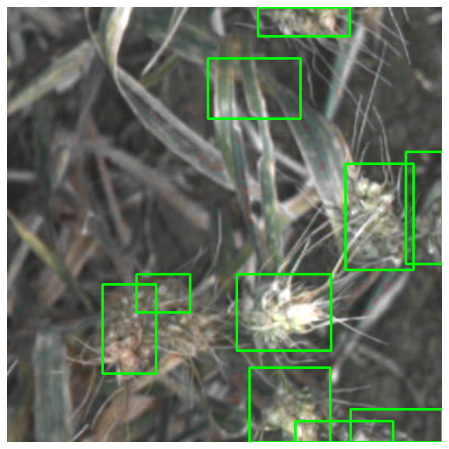

In [24]:
image, target, image_id = training_dataset[np.random.randint(2000)]
boxes = target['boxes'].cpu().numpy().astype(np.int32)
#converting the image from 1024x1024x3 torch tensor to a 1024x3x1024 numpy array
numpy_image = image.permute(1,2,0).cpu().numpy().astype(np.float32)
#plotting

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

## The Network
The network, that will be used here is the 0.14 build of EfficientDet in PyTorch.

### Building the Network
First the network will be configured.


### get_net()

In [25]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

model_type = 'd5'

def get_net():
    '''Set up the model that will be used for training
    
    Returns:
        effdet.bench.DetBenchPredict object: model, ready for training
        
    '''
    #get a starting configuratino for the model
    config = get_efficientdet_config('tf_efficientdet_d5')
    #instantiating the EfficientDet object
    net = EfficientDet(config = config, pretrained_backbone = False)
    #loading a checkpoint
    checkpoint_paths = r'../input/efficientdet/*'+model_type+r'*.pth'
    checkpoint_path = glob(checkpoint_paths)[0]
    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint)
    #We only have one class: Wheat
    config.num_classes = 1
    config.image_size = 1024*scale
    #Set up the Head
    net.class_net = HeadNet(config, num_outputs = config.num_classes, norm_kwargs = dict(eps=.001, momentum = 0.1))
    return DetBenchTrain(net, config)

### The Training Function

Next the code to train the network will be created.

### The Config Class

This class contains the configuration settings for the network.

In [26]:
class TrainGlobalConfig:
    '''Class to hold settings that will be used during training
    
    Attributes:
        num_workers(int): number of tasks to use when loading the dataset
        batch_size(int): batch size to use during training
        n_epochs(int): number of epochs to train
        lr(float): initial learning rate
        folder('str'): folder to store the log and checkpoints in during training
        test(boolean): determine whether to put the training class object into test mode
        verbose(boolean): choose whether to print a lot of information during training
        mixed_precision(boolean): use mixed-precision training
        accumulate(int): number of entries to accumulate during mixed-precision training
        step_scheduler(boolean): iterate the scheduler after optimizer step
        valdiation_scheduler(boolean): iterate the scheduler after validation step
        SchedulerClass(class): class of scheduler to use
        scheduler_params(dict): dictionary containing the settings of the scheduler
    '''
    num_workers = 2
    batch_size = 4
    n_epochs = 1 #n_epochs = 40
    lr = 0.0002 #learning rate
    folder = 'effdet-experimental'
    test = False
    #-------------
    verbose = True
    verbose_step = 1
    #APEX
    mixed_precision = True
    accumulate = 8
    #-------------
    step_scheduler = False #scheduler after optimizer.step
    validation_scheduler = True #scheduler.step after validation
    #---------------
#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=int(len(train_dataset) / batch_size),
#         pct_start=0.1,
#         anneal_strategy='cos', 
#         final_div_factor=10**5
#     )
    #-------------
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode = 'min',
        factor = 0.5,
        patience = 1,
        verbose = False,
        threshold_mode = 'abs',
        cooldown = 0,
        min_lr = 1e-8,
        eps = 1e-08
    )

In [27]:
def collate_fn(batch):
    '''Transform batch of images and their data for use by the network'''
    return tuple(zip(*batch))

### The Average Meter Class

This class will be used to monitor the loss function and to update the network in between epochs

In [28]:
class AverageMeter(object):
    '''Computes and stores the average and current value.
    
    Attributes:
        self.val(float): current value stored in object 
        self.sum(float): value*n
        self.count(int): count of items
        self.avg(float): average value of values
    '''
    def __init__(self):
        '''Intializes a reset AverageMeter object.'''
        self.reset()
    def reset(self):
        '''Resets AverageMeter object to values of all 0.'''
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n=1):
        '''Updates the values of the AverageMeter object
        
        Args:
            val(float): value to use for the update (typically loss)
            n(int)=1: number of items added (typically batch size)
        '''
        self.val = val
        self.sum = val * n
        self.count += n
        self.avg = self.sum / self.count

### Data Loader

Create objects, that can then be iterated over to produce the individual entries

In [29]:
train_loader = torch.utils.data.DataLoader(training_dataset,
                                           batch_size=TrainGlobalConfig.batch_size,
                                           pin_memory = False,
                                           drop_last = True,
                                           shuffle = True,
                                           collate_fn = collate_fn)

val_loader = torch.utils.data.DataLoader(validation_dataset,
                                         batch_size=TrainGlobalConfig.batch_size,
                                         pin_memory = False,
                                         drop_last = True,
                                         shuffle = True,
                                         collate_fn = collate_fn)

### The Fitter Class

Next a class has to be made in order to fit the model to the training data

In [30]:
class Fitter:
    '''Class containing functions to train the model
    
    Attributes:
        self.config(class): class with configuration settings
        self.epoch(int): current training epoch
        self.base_dir(str): path to the folder in which to store checkpoints
        self.log_path(str): path to the log file
        self.device(torch.device object): device to use for training
        self.model(effdet.bench.DetBenchPredict object): model to use for training
        self.optimizer(torch.optim object): optimizer to use for training
        self.best_summary_loss(float): previous lowest summary loss during training
        self.scheduler(torch.optim object): scheduler to use
        self.mixed_precision(boolean): determines wheter to use mixed precision training
        self.accumulate(int): number of items accumulated by NVIDIA Apex
        
    '''
    def __init__(self, model, device, config):
        '''Initialize Fitter() object
        
        Args:
            model(effdet.bench.DetBenchPredict object): model to use for training
            device(torch.device object): device to use for training
            config(class): class with configuration settings
        '''
        self.config = config
        self.epoch = 0
        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        self.log_path = f'./{config.folder}/log.txt'
        self.device = device
        self.model = model
        self.model.to(device)
        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        
        self.optimizer = torch.optim.AdamW(self.model.parameters(),lr = config.lr)
        self.best_summary_loss = 10**5
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.mixed_precision = config.mixed_precision
        self.accumulate = config.accumulate
        if self.mixed_precision:
            'initialize amp'
            self.model, self.optimizer = amp.initialize(self.model, self.optimizer, opt_level="O1", verbosity=0)
        self.log(f'Fitter prepared. Device is {torch.cuda.get_device_name(device = self.device)}')
        
    def fit(self, train_loader, validation_loader):
        '''Fit the model using the settings in the config class
        Args:
            train_loader(torch.utils.data.dataloader.DataLoader object): object containing
                training data
            validation_loader(torch.utils.data.dataloader.DataLoader): object containing
                validation data
        '''
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.today().isoformat()
                print('epoch',self.epoch)
                self.log(f'\n{timestamp}\nLR: {lr}')
            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)
            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss : {summary_loss.avg:.5f}, time: {time.time()-t}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')
            t = time.time()
            summary_loss = self.validation(validation_loader)
            
            self.log(f'[RESULT]: VAL. Epoch: {self.epoch}, summay_loss: {summary_loss.avg:.5f}, time:{(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)
                if self.config.validation_scheduler:
                    self.scheduler.step(metrics = summary_loss.avg)
            self.epoch += 1
    def train_one_epoch(self, train_loader):
        '''Train the model for one epoch.
        Args:
            train_loader(torch.utils.data.dataloader.DataLoader object): object containing
                training data
        
        Returns:
            AverageMeter object: contains information on summary loss during training epoch
        '''
        self.model.train()
        summary_loss = AverageMeter()
        for step, (images, targets , image_ids) in enumerate(train_loader):
            images = torch.stack(images)
            images = images.cuda()
            batch_size = images.shape[0]
            boxes = [target['boxes'].cuda().float() for target in targets]
            lbls = [target['labels'].cuda().float() for target in targets]
            target_res = {}
            target_res['bbox'] = boxes
            target_res['cls'] = lbls
            target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * batch_size,
                                                  dtype=torch.float).to(self.device)
            self.optimizer.zero_grad()
            loss = self.model(images, target_res)['loss']
            if self.mixed_precision:
                with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            if (step+1) % self.accumulate == 0:
                self.optimizer.step()
                self.optimizer.zero_grad()    
            
            summary_loss.update(loss.detach().item(), batch_size)
            self.optimizer.step()
            if self.config.step_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)
        return summary_loss
    
    def validation(self, val_loader):
        '''Validate the model after training for one epoch.
        Args:
            val_loader(torch.utils.data.dataloader.DataLoader object): object containing
                validation data
        
        Returns:
            AverageMeter object: contains information on summary loss during validation step
        '''
        self.model.eval()
        summary_loss = AverageMeter()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.cuda().float()
                boxes = [target['boxes'].cuda().float() for target in targets]
                lbls = [target['labels'].cuda().float() for target in targets]
                target_res = {}
                target_res['bbox'] = boxes
                target_res['cls'] = lbls
                target_res['img_scale'] = torch.tensor([1.0] * batch_size, dtype = torch.float32).to(self.device)
                target_res['img_size'] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float32).to(self.device)
                self.optimizer.zero_grad()
                loss = self.model(images, target_res)['loss']
                summary_loss.update(loss.detach().item(),batch_size)
        return summary_loss
    def log(self, message):
        '''Write a message to the training log file
        
        Args:
            message(str): message to write
        '''
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')
    def save(self, path):
        '''Save current model state to checkpoint.
        Args:
            path(str): path of the chekcpoint to be created
        '''
        self.model.eval()
        if self.mixed_precision:
            torch.save({
                'model_state_dict': self.model.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
                'best_summary_loss': self.best_summary_loss,
                'epoch':self.epoch,
                'amp': amp.state_dict()
            }, path)
        else:
            torch.save({
                'model_state_dict': self.model.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
                'best_summary_loss': self.best_summary_loss,
                'epoch':self.epoch,
            }, path)
            
        
    def load(self, path):
        '''Load model state from checkpoint.
        Args:
            path(str): path of checkpoint file
        '''
        if self.config.verbose:
            print('loading started.')
            t0 = time.time()
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        amp.load_state_dict(checkpoint['amp'])
        
        del checkpoint
        import gc
        gc.collect()
        if self.config.verbose:
            print(f'loading done. Time: {time.time()-t0}')

In [31]:
folder = TrainGlobalConfig.folder
file = f'{folder}/last-checkpoint.bin'

### Run Training

In [32]:
def run_training():
    device = torch.device('cuda:0')
    fitter = Fitter(model=net, device = device, config = TrainGlobalConfig)
    fitter.load(file) #comment out if training a model from scratch
    fitter.fit(train_loader, val_loader)

In [33]:
net = get_net()

In [ ]:
run_training()

Fitter prepared. Device is GeForce RTX 2080 Ti
loading started.
loading done. Time: 0.8759994506835938
epoch 17

2020-08-27T11:36:55.664423
LR: 0.0002
